# Brute Force

In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from shapely.ops import transform
import matplotlib.patches as patches
from shapely.geometry import Polygon, box, mapping
from shapely.ops import unary_union
from pyproj import Transformer, CRS
import numpy as np
from typing import List, Tuple

from shapely.affinity import rotate

import plotly.graph_objects as go

import ipywidgets as widgets
from IPython.display import display, HTML

from matplotlib.patches import Polygon as MplPolygon
import time

from shapely.strtree import STRtree
from shapely.prepared import prep
from shapely.strtree import STRtree
from shapely.prepared import prep

import numpy as np
from shapely.geometry import Polygon, box
from shapely.affinity import rotate
from pyproj import CRS, Transformer

from collections import deque
from collections import deque
import numpy as np
from shapely.geometry import box
from shapely.affinity import rotate

from aquarel import load_theme
import matplotlib.style as mplstyle
mplstyle.core.USER_LIBRARY_PATHS.append('/home/kb/anaconda3/envs/myenv/lib/python3.13/site-packages/aquarel/styles')

In [2]:
def extract_polygons_from_kml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    # KML namespace
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}

    polygons = []

    # Find ALL <coordinates> inside ANY <Polygon>
    for coords in root.findall(".//kml:Polygon//kml:coordinates", ns):
        text = coords.text.strip()
        pts = []

        for line in text.split():
            lon, lat, *_ = line.split(',')
            pts.append((float(lon), float(lat)))

        polygons.append(pts)

    return polygons

In [3]:
polygons = extract_polygons_from_kml("valid.kml")
print("Found polygons:", len(polygons))

#for p in polygons:
#    print(p[:3], "...")


Found polygons: 10


In [4]:
def generate_offsets(rect_w = 1, rect_h = 1, w_res = 100, h_res = 100, res_mode = "land"):
    if res_mode == "rect":
        step_w = rect_w / w_res
        step_h = rect_h / h_res
    elif res_mode == "land":
        step_w = 1 / w_res
        step_h = 1 / h_res
    else:
        raise ValueError("Mode not selected")

    offsets = []
    for j in range(h_res):
        for i in range(w_res):
            offsets.append((
                round(i * step_w, 6),
                round(j * step_h, 6)
            ))
    return offsets

In [8]:
def point_in_poly_numpy(xs, ys, poly_xy):
    px = poly_xy[:, 0]
    py = poly_xy[:, 1]

    n = len(px)
    inside = np.zeros(xs.shape, dtype=bool)

    x1 = px
    y1 = py
    x2 = np.roll(px, -1)
    y2 = np.roll(py, -1)

    for i in range(n):
        denom = (y2[i] - y1[i])
        denom = denom if np.abs(denom) > 1e-15 else (1e-15 * np.sign(denom) if denom != 0 else 1e-15)
        cond = ((y1[i] > ys) != (y2[i] > ys)) & (
            xs < ((x2[i] - x1[i]) * (ys - y1[i]) / denom + x1[i])
        )
        inside ^= cond

    return inside


In [ ]:
def pack_rectangles_in_polygon_brute_force(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=60,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,
):
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)
    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local_coords = np.array([to_local(lon, lat) for lon, lat in polygon_lonlat])
    poly_local = Polygon(poly_local_coords)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return []

    rot_origin = poly_local.centroid
    poly_rot_shp = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot_shp = poly_rot_shp.buffer(-pad_m)
        if poly_rot_shp.is_empty:
            return []

    minx, miny, maxx, maxy = poly_rot_shp.bounds

    if try_offsets == True:
        offsets = generate_offsets(
            rect_w=rect_w_m, rect_h=rect_h_m,
            w_res=w_res, h_res=h_res, res_mode=res_mode
        )
    elif try_offsets == "half":
        offsets = [
            (0,0),(rect_w_m/2,0),(0,rect_h_m/2),(rect_w_m/2,rect_h_m/2)
        ]
    else:
        offsets = [(0,0)]

    best_rects = []
    best_count = -1
    all_rects = []
    cw = rect_w_m
    ch = rect_h_m

    if Is_Convex:
        # -------- FAST 4-CORNER CHECK --------
        poly_rot = np.array(poly_rot_shp.exterior.coords)
        dx = np.array([0, cw, cw, 0])
        dy = np.array([0, 0, ch, ch])

        for ox, oy in offsets:
            xs = np.arange(minx - cw + ox, maxx + cw, cw)
            ys = np.arange(miny - ch + oy, maxy + ch, ch)

            if xs.size == 0 or ys.size == 0:
                continue

            XX, YY = np.meshgrid(xs, ys, indexing="xy")
            base_x = XX.ravel()
            base_y = YY.ravel()

            all_x = base_x[:, None] + dx[None, :]
            all_y = base_y[:, None] + dy[None, :]

            inside = point_in_poly_numpy(all_x, all_y, poly_rot)
            valid_mask = np.all(inside, axis=1)
            valid_idx = np.nonzero(valid_mask)[0]

            rects = []
            for i in valid_idx:
                x0 = base_x[i]
                y0 = base_y[i]
                rects.append(box(x0, y0, x0 + cw, y0 + ch))

            if store_all:
                for i in range(len(base_x)):
                    all_rects.append(box(base_x[i], base_y[i], base_x[i]+cw, base_y[i]+ch))

            if len(rects) > best_count:
                best_count = len(rects)
                best_rects = rects

    else:
        # -------- SLOW COVER CHECK --------
        for ox, oy in offsets:
            start_x = minx - cw
            start_y = miny - ch
            xs = np.arange(start_x + ox, maxx + cw, cw)
            ys = np.arange(start_y + oy, maxy + ch, ch)

            rects = []
            for x in xs:
                for y in ys:
                    candidate = box(x, y, x + cw, y + ch)
                    if store_all:
                        all_rects.append(candidate)
                    if poly_rot_shp.covers(candidate):
                        rects.append(candidate)

            if len(rects) > best_count:
                best_count = len(rects)
                best_rects = rects

    result = []
    centers = []
    all_result = []

    # --- Sort rectangles row-wise instead of column-wise ---
    best_rects = sorted(best_rects, key=lambda r: (r.bounds[1], r.bounds[0])) # (miny, minx)


    for r in best_rects:
        r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
        coords = np.array(r_back.exterior.coords)[:-1]
        coords_ll = [to_wgs84(x,y) for x,y in coords]
        result.append(coords_ll)
        c = r_back.centroid
        centers.append(to_wgs84(c.x, c.y))

    if store_all:
        for r in all_rects:
            r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
            coords = np.array(r_back.exterior.coords)[:-1]
            coords_ll = [to_wgs84(x,y) for x,y in coords]
            all_result.append(coords_ll)
            c = r_back.centroid
            centers.append(to_wgs84(c.x, c.y))

    return result, best_count, best_rects, poly_rot_shp, centers, all_result

In [10]:
def pack_rectangles_bfs_dfs_combined(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=60,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,
    search_mode="DFS"
):
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return [], 0, [], None, [], []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)
    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local_coords = np.array([to_local(lon, lat) for lon, lat in polygon_lonlat])
    poly_local = Polygon(poly_local_coords)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return [], 0, [], None, [], []

    rot_origin = poly_local.centroid
    poly_rot_shp = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot_shp = poly_rot_shp.buffer(-pad_m)
        if poly_rot_shp.is_empty:
            return [], 0, [], None, [], []

    minx, miny, maxx, maxy = poly_rot_shp.bounds
    cw = rect_w_m
    ch = rect_h_m

    if try_offsets == True:
        offsets = generate_offsets(rect_w=rect_w_m, rect_h=rect_h_m, w_res=w_res, h_res=h_res, res_mode=res_mode)
    elif try_offsets == "half":
        offsets = [(0,0),(rect_w_m/2,0),(0,rect_h_m/2),(rect_w_m/2,rect_h_m/2)]
    else:
        offsets = [(0,0)]

    best_rects = []
    best_count = -1
    best_centers = []
    best_all = []

    if Is_Convex:
        poly_rot = np.array(poly_rot_shp.exterior.coords)
        dx = np.array([0, cw, cw, 0])
        dy = np.array([0, 0, ch, ch])

        def rect_valid_by_xy(x, y):
            all_x = x + dx
            all_y = y + dy
            inside = point_in_poly_numpy(all_x[None, :], all_y[None, :], poly_rot)
            return inside.ravel().all()
    else:
        def rect_valid_by_xy(x, y):
            return poly_rot_shp.covers(box(x, y, x + cw, y + ch))

    neigh = [(1,0),(-1,0),(0,1),(0,-1)]

    for ox, oy in offsets:
        start_x = minx - cw
        start_y = miny - ch

        nx = int(np.ceil((maxx + cw - (start_x + ox)) / cw))
        ny = int(np.ceil((maxy + ch - (start_y + oy)) / ch))
        if nx <= 0 or ny <= 0:
            continue

        def idx_to_xy(i, j):
            return (start_x + ox + i * cw, start_y + oy + j * ch)

        centroid_rot = rotate(poly_local.centroid, -angle_deg, origin=rot_origin, use_radians=False)
        seed_x, seed_y = centroid_rot.x, centroid_rot.y
        seed_i = int(round((seed_x - (start_x + ox)) / cw))
        seed_j = int(round((seed_y - (start_y + oy)) / ch))
        seed_i = max(0, min(nx-1, seed_i))
        seed_j = max(0, min(ny-1, seed_j))

        if search_mode == "BFS":
            rects, centers, examined = bfs_fill(
                seed_i, seed_j, nx, ny,
                idx_to_xy, rect_valid_by_xy,
                store_all, neigh,
                cw, ch, poly_rot_shp
            )
        else:
            rects, centers, examined = dfs_fill(
                seed_i, seed_j, nx, ny,
                idx_to_xy, rect_valid_by_xy,
                store_all, neigh,
                cw, ch, poly_rot_shp
            )

        if len(rects) > best_count:
            best_count = len(rects)
            best_rects = rects
            best_centers = centers
            best_all = examined

    result = []
    centers_ll = []
    all_result = []
    rot_origin_geom = rot_origin

    for r in best_rects:
        r_back = rotate(r, angle_deg, origin=rot_origin_geom, use_radians=False)
        coords = np.array(r_back.exterior.coords)[:-1]
        coords_ll = [to_wgs84(x, y) for x, y in coords]
        result.append(coords_ll)
        c = r_back.centroid
        centers_ll.append(to_wgs84(c.x, c.y))

    if store_all:
        for r in best_all:
            r_back = rotate(r, angle_deg, origin=rot_origin_geom, use_radians=False)
            coords = np.array(r_back.exterior.coords)[:-1]
            coords_ll = [to_wgs84(x, y) for x, y in coords]
            all_result.append(coords_ll)

    return result, best_count, best_rects, poly_rot_shp, centers_ll, all_result

In [11]:
def rect_valid_by_xy_convex(x, y, dx, dy, poly_rot):
    all_x = x + dx
    all_y = y + dy
    inside = point_in_poly_numpy(all_x[None, :], all_y[None, :], poly_rot)
    return inside.ravel().all()

In [12]:
def rect_valid_by_xy_concave(x, y, poly_rot_shp, cw, ch):
    return poly_rot_shp.covers(box(x, y, x + cw, y + ch))

In [13]:
def bfs_fill(
    start_i, start_j, nx, ny,
    idx_to_xy, rect_valid_f,
    store_all, neigh,
    cw, ch, poly_rot_shp
):
    q = deque()
    q.append((start_i, start_j))
    visited = set()
    rects = []
    centers = []
    examined = []

    while q:
        i, j = q.popleft()
        if (i, j) in visited:
            continue
        visited.add((i, j))

        if i < 0 or i >= nx or j < 0 or j >= ny:
            continue

        x, y = idx_to_xy(i, j)
        candidate = box(x, y, x + cw, y + ch)

        if store_all:
            examined.append(candidate)

        valid = rect_valid_f(x, y)

        if valid:
            rects.append(candidate)
            centers.append(candidate.centroid)
            for di, dj in neigh:
                ni, nj = i + di, j + dj
                if (ni, nj) not in visited:
                    q.append((ni, nj))

    return rects, centers, examined

In [14]:
def dfs_fill(
    start_i, start_j, nx, ny,
    idx_to_xy, rect_valid_f,
    store_all, neigh,
    cw, ch, poly_rot_shp
):
    stack = [(start_i, start_j)]
    visited = set()
    rects = []
    centers = []
    examined = []

    while stack:
        i, j = stack.pop()
        if (i, j) in visited:
            continue
        visited.add((i, j))

        if i < 0 or i >= nx or j < 0 or j >= ny:
            continue

        x, y = idx_to_xy(i, j)
        candidate = box(x, y, x + cw, y + ch)

        if store_all:
            examined.append(candidate)

        valid = rect_valid_f(x, y)

        if valid:
            rects.append(candidate)
            centers.append(candidate.centroid)
            for di, dj in neigh:
                ni, nj = i + di, j + dj
                if (ni, nj) not in visited:
                    stack.append((ni, nj))

    return rects, centers, examined

In [15]:
def get_seed_index(seed_x, seed_y, start_x, start_y, ox, oy, cw, ch, nx, ny):
    seed_i = int(round((seed_x - (start_x + ox)) / cw))
    seed_j = int(round((seed_y - (start_y + oy)) / ch))
    seed_i = max(0, min(nx - 1, seed_i))
    seed_j = max(0, min(ny - 1, seed_j))
    return seed_i, seed_j

In [16]:
def pack_rectangles_bfs_dfs_combined(
    polygon_lonlat,
    rect_w_m,
    rect_h_m,
    try_offsets,
    w_res=100,
    h_res=100,
    res_mode="land",
    angle_deg=60,
    store_all=False,
    pad_m=0.0,
    Is_Convex=False,
    search_mode="DFS"
):
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return [], 0, [], None, [], []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)
    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local_coords = np.array([to_local(lon, lat) for lon, lat in polygon_lonlat])
    poly_local = Polygon(poly_local_coords)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return [], 0, [], None, [], []

    rot_origin = poly_local.centroid
    poly_rot_shp = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)

    if pad_m > 0:
        poly_rot_shp = poly_rot_shp.buffer(-pad_m)
        if poly_rot_shp.is_empty:
            return [], 0, [], None, [], []

    minx, miny, maxx, maxy = poly_rot_shp.bounds
    cw = rect_w_m
    ch = rect_h_m

    if try_offsets is True:
        offsets = generate_offsets(rect_w=cw, rect_h=ch, w_res=w_res, h_res=h_res, res_mode=res_mode)
    elif try_offsets == "half":
        offsets = [(0, 0), (cw / 2, 0), (0, ch / 2), (cw / 2, ch / 2)]
    else:
        offsets = [(0, 0)]

    best_rects = []
    best_count = -1
    best_centers = []
    best_all = []

    neigh = [(1,0),(-1,0),(0,1),(0,-1)]

    if Is_Convex:
        poly_rot = np.array(poly_rot_shp.exterior.coords)
        dx = np.array([0, cw, cw, 0])
        dy = np.array([0, 0, ch, ch])
        def rect_valid_f(x, y):
            return rect_valid_by_xy_convex(x, y, dx, dy, poly_rot)
    else:
        def rect_valid_f(x, y):
            return rect_valid_by_xy_concave(x, y, poly_rot_shp, cw, ch)

    for ox, oy in offsets:
        start_x = minx - cw
        start_y = miny - ch
        nx = int(np.ceil((maxx + cw - (start_x + ox)) / cw))
        ny = int(np.ceil((maxy + ch - (start_y + oy)) / ch))
        if nx <= 0 or ny <= 0:
            continue

        def idx_to_xy(i, j):
            return (start_x + ox + i * cw, start_y + oy + j * ch)

        centroid_rot = rotate(poly_local.centroid, -angle_deg, origin=rot_origin, use_radians=False)

        seed_i, seed_j = get_seed_index(
            centroid_rot.x, centroid_rot.y,
            start_x, start_y, ox, oy,
            cw, ch, nx, ny
        )

        if search_mode == "BFS":
            rects, centers, examined = bfs_fill(
                seed_i, seed_j, nx, ny,
                idx_to_xy, rect_valid_f,
                store_all, neigh,
                cw, ch, poly_rot_shp
            )
        else:
            rects, centers, examined = dfs_fill(
                seed_i, seed_j, nx, ny,
                idx_to_xy, rect_valid_f,
                store_all, neigh,
                cw, ch, poly_rot_shp
            )

        if len(rects) > best_count:
            best_count = len(rects)
            best_rects = rects
            best_centers = centers
            best_all = examined

    result = []
    centers_ll = []
    all_result = []

    for r in best_rects:
        r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
        coords = np.array(r_back.exterior.coords)[:-1]
        result.append([to_wgs84(x, y) for x, y in coords])
        c = r_back.centroid
        centers_ll.append(to_wgs84(c.x, c.y))

    if store_all:
        for r in best_all:
            r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
            coords = np.array(r_back.exterior.coords)[:-1]
            all_result.append([to_wgs84(x, y) for x, y in coords])

    return result, best_count, best_rects, poly_rot_shp, centers_ll, all_result

In [17]:
def plot_maplibre_rectangles(
    polygon_lonlat,
    rects_lonlat,
    centers,
    rect_w_m,
    rect_h_m,
    max_count,
    bearing=0,
    pad_m=0.0,
    map_mode="white"
):
    import plotly.graph_objects as go
    from shapely.geometry import Polygon
    from pyproj import CRS, Transformer

    xs = [p[0] for p in polygon_lonlat]
    ys = [p[1] for p in polygon_lonlat]

    centroid_lon = sum(xs) / len(xs)
    centroid_lat = sum(ys) / len(ys)

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={centroid_lat} +lon_0={centroid_lon} "
        f"+units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)

    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local = Polygon([to_local(lon, lat) for lon, lat in polygon_lonlat])

    if pad_m > 0:
        poly_padded_local = poly_local.buffer(-pad_m)
        if poly_padded_local.is_empty:
            padded_lonlat = []
        else:
            padded_lonlat = [to_wgs84(x, y) for x, y in poly_padded_local.exterior.coords]
    else:
        padded_lonlat = []

    fig = go.Figure()

    lon_poly = [p[0] for p in polygon_lonlat]
    lat_poly = [p[1] for p in polygon_lonlat]

    fig.add_trace(
        go.Scattermap(
            lon=lon_poly + [lon_poly[0]],
            lat=lat_poly + [lat_poly[0]],
            fill="toself",
            fillcolor="rgba(150,150,150,0.5)" if map_mode == "street" else "rgba(150,150,150,0.3)",
            line=dict(width=2, color="black"),
            mode="lines",
            name="Polygon",
        )
    )

    if len(padded_lonlat) > 0:
        lon_pad = [p[0] for p in padded_lonlat]
        lat_pad = [p[1] for p in padded_lonlat]

        fig.add_trace(
            go.Scattermap(
                lon=lon_pad + [lon_pad[0]],
                lat=lat_pad + [lat_pad[0]],
                mode="lines",
                line=dict(width=2, color="red"),
                name="Inner Padded Polygon",
            )
        )

    for i, rect in enumerate(rects_lonlat):
        lon_r = [p[0] for p in rect] + [rect[0][0]]
        lat_r = [p[1] for p in rect] + [rect[0][1]]

        fig.add_trace(
            go.Scattermap(
                lon=lon_r,
                lat=lat_r,
                mode="lines",
                line=dict(width=1, color="blue"),
                name=f"Rectangle {i+1}",
            )
        )

        cx, cy = centers[i]
        font_size = max(10, min(rect_w_m, rect_h_m) * 0.6)

        fig.add_trace(
            go.Scattermap(
                lon=[cx],
                lat=[cy],
                mode="text",
                text=[str(i + 1)],
                textfont=dict(size=font_size, color="black"),
                name=f"Label {i+1}",
            )
        )

    map_style = "open-street-map" if map_mode == "street" else "white-bg"

    fig.update_layout(
        map=dict(
            style=map_style,
            center={"lat": centroid_lat, "lon": centroid_lon},
            zoom=16,
            bearing=bearing,
            pitch=0,
        ),
        margin=dict(l=0, r=0, t=50, b=0),
        title=f"Max count: {max_count}",
        showlegend=False,
    )

    fig.show()


In [18]:
plt.style.use('./Themes/pitayasmoothie-light.mplstyle')

In [19]:
def plot_matplotlib_rectangles(
    polygon_lonlat,
    rects_lonlat,
    centers,
    rect_w_m,
    rect_h_m,
    max_count,
    bearing=0,
    pad_ratio=0.05,
    pad_m=0.0
):
    xs = [p[0] for p in polygon_lonlat]
    ys = [p[1] for p in polygon_lonlat]

    centroid_lon = sum(xs) / len(xs)
    centroid_lat = sum(ys) / len(ys)

    aeq_crs = CRS.from_proj4(
        f"+proj=aeqd +lat_0={centroid_lat} +lon_0={centroid_lon} +units=m +datum=WGS84 +no_defs"
    )
    wgs84 = CRS.from_epsg(4326)
    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_local = Polygon([to_local(lon, lat) for lon, lat in polygon_lonlat])

    if pad_m > 0:
        poly_padded_local = poly_local.buffer(-pad_m)
        if poly_padded_local.is_empty:
            poly_padded_lonlat = []
        else:
            poly_padded_lonlat = [to_wgs84(x, y) for x, y in poly_padded_local.exterior.coords]
    else:
        poly_padded_lonlat = []

    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    width = max_x - min_x
    height = max_y - min_y
    width = max(width, 1e-9)
    height = max(height, 1e-9)
    aspect = width / height

    pad_x = width * pad_ratio
    pad_y = height * pad_ratio

    min_x_p = min_x - pad_x
    max_x_p = max_x + pad_x
    min_y_p = min_y - pad_y
    max_y_p = max_y + pad_y

    base_h = 8
    fig_w = base_h * aspect
    fig_h = base_h

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    ax.add_patch(MplPolygon(
        polygon_lonlat,
        closed=True,
        facecolor=(0.6, 0.6, 0.6, 0.7),
        edgecolor="black",
        linewidth=2
    ))

    if len(poly_padded_lonlat) > 0:
        ax.add_patch(MplPolygon(
            poly_padded_lonlat,
            closed=True,
            fill=False,
            edgecolor="red",
            linewidth=2,
            linestyle="--"
        ))

    for i, rect in enumerate(rects_lonlat):
        ax.add_patch(MplPolygon(rect, closed=True, fill=False, edgecolor="blue", linewidth=1))
        cx, cy = centers[i]
        font_size = max(10, min(rect_w_m, rect_h_m) * 0.6)
        ax.text(cx, cy, str(i+1), ha="center", va="center", fontsize=font_size)

    ax.text(
        0.98, 0.98,
        f"Max count: {max_count}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=25,
        fontweight="bold",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2")
    )

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect("equal", adjustable="datalim")
    ax.set_xlim(min_x_p, max_x_p)
    ax.set_ylim(min_y_p, max_y_p)

    plt.tight_layout()
    plt.show()


In [20]:
current_polygon = polygons[0]
width = 10
height = 3
x_res = 100
y_res = 100
angle = 30
boundary_padding = 3

In [21]:
"""start = time.time()
a, b, c, poly_local, centers, d = pack_rectangles_in_polygon_rot(
    polygon_lonlat=current_polygon,
    rect_w_m=width,
    rect_h_m=height,
    try_offsets=True,
    w_res=x_res,
    h_res=y_res,
    res_mode="land",
    angle_deg=angle,
    pad_m=boundary_padding
)
end = time.time()

print("Old",{end - start},"Max Count",{b})"""

'start = time.time()\na, b, c, poly_local, centers, d = pack_rectangles_in_polygon_rot(\n    polygon_lonlat=current_polygon,\n    rect_w_m=width,\n    rect_h_m=height,\n    try_offsets=True,\n    w_res=x_res,\n    h_res=y_res,\n    res_mode="land",\n    angle_deg=angle,\n    pad_m=boundary_padding\n)\nend = time.time()\n\nprint("Old",{end - start},"Max Count",{b})'

In [22]:
start = time.time()
a, b, c, poly_local, centers, d = pack_rectangles_bfs_dfs_combined(
    polygon_lonlat=current_polygon,
    rect_w_m=width,
    rect_h_m=height,
    try_offsets=True,
    w_res=x_res,
    h_res=y_res,
    res_mode="land",
    angle_deg=angle,
    pad_m=boundary_padding,
    Is_Convex=False,
    search_mode="DFS"
)
end = time.time()

print(f"Time Taken: {end - start}, Max Count:{b}")

Time Taken: 91.2783875465393, Max Count:151


In [23]:
start = time.time()
a, b, c, poly_local, centers, d = pack_rectangles_bfs_dfs_combined(
    polygon_lonlat=current_polygon,
    rect_w_m=width,
    rect_h_m=height,
    try_offsets=True,
    w_res=x_res,
    h_res=y_res,
    res_mode="land",
    angle_deg=angle,
    pad_m=boundary_padding,
    Is_Convex=False,
    search_mode="BFS"
)
end = time.time()

print(f"Time Taken: {end - start}, Max Count:{b}")

Time Taken: 90.6272623538971, Max Count:151


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


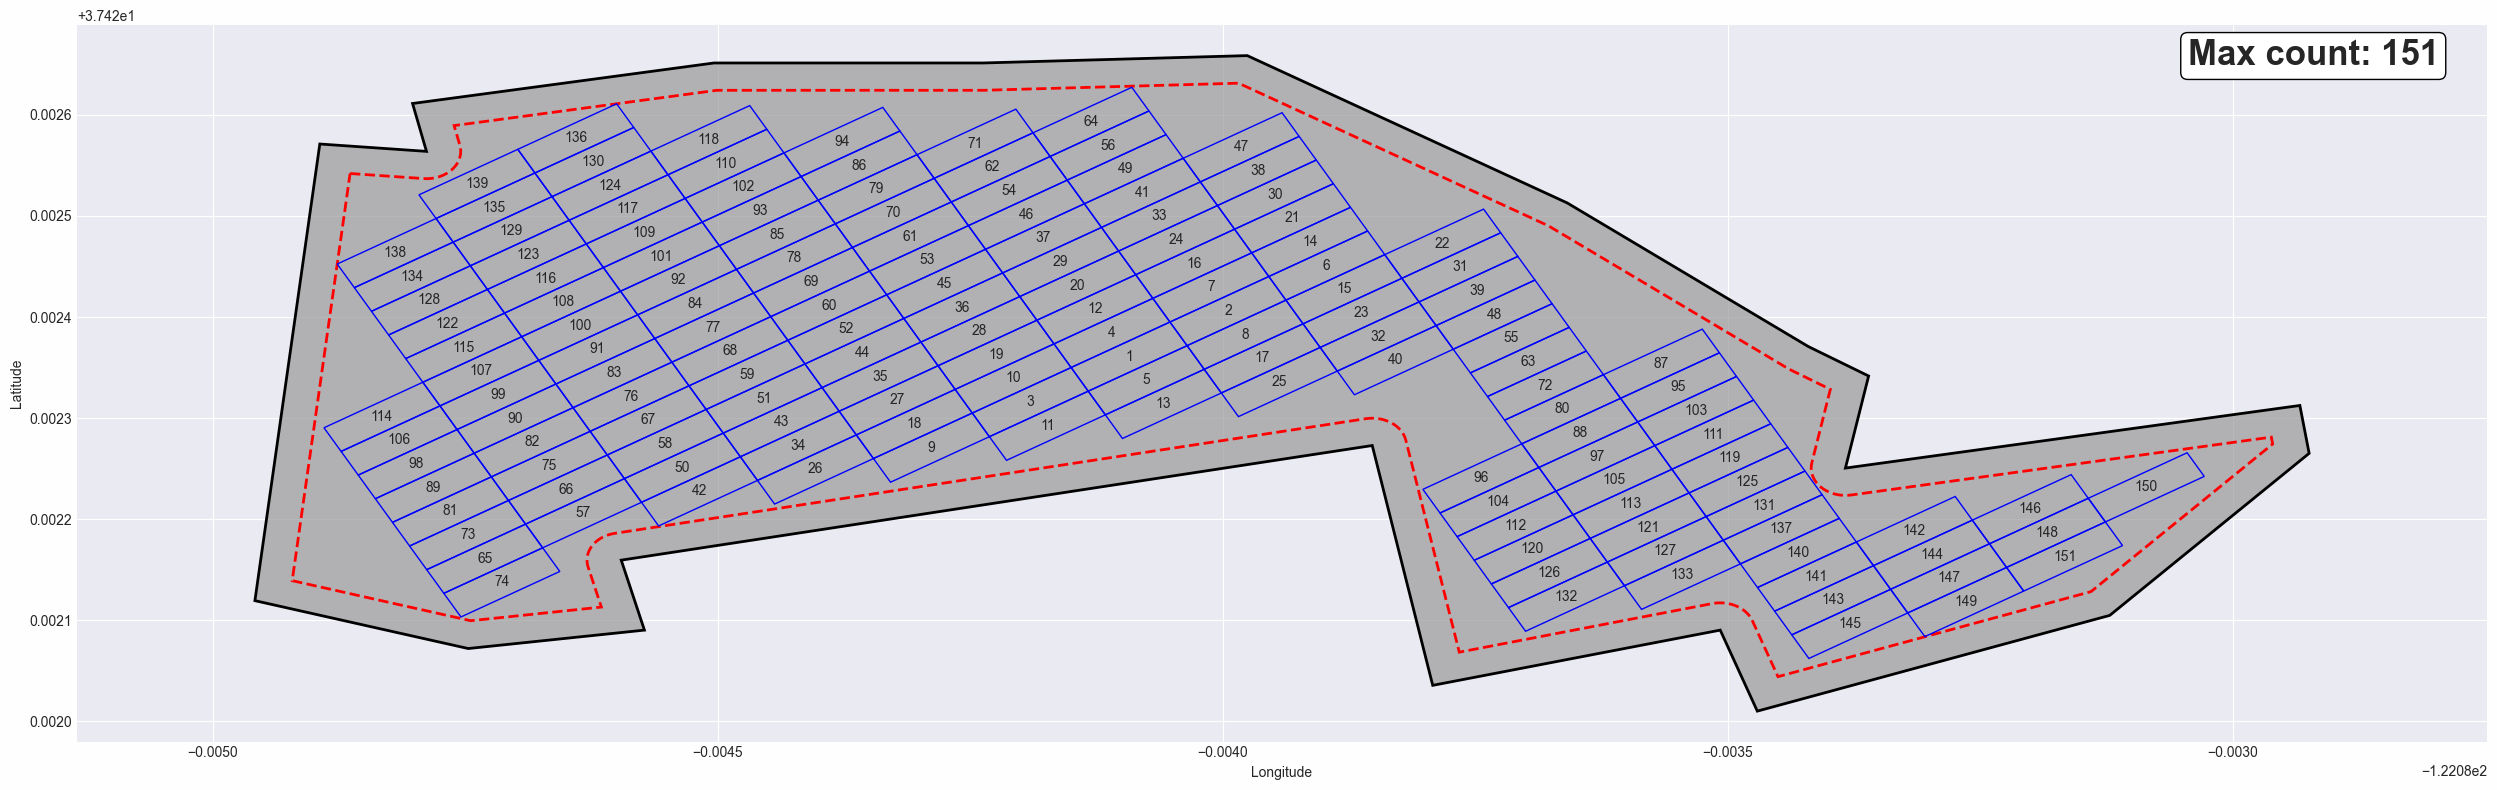

In [24]:
plot_matplotlib_rectangles(
    polygon_lonlat=current_polygon,
    rects_lonlat=a,
    centers=centers,
    rect_w_m=width,
    rect_h_m=height,
    max_count=b,
    bearing=0,
    pad_m=boundary_padding)

In [25]:
plot_maplibre_rectangles(
    polygon_lonlat=current_polygon,
    rects_lonlat=a,
    centers=centers,
    rect_w_m=width,
    rect_h_m=height,
    max_count=b,
    bearing=0,
    pad_m=boundary_padding)